In [1]:
import re
import os
import jax
import pickle
import jax.numpy as jnp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [406]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

plt.rcParams["font.size"] = 14
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["lines.linewidth"] = 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [407]:
def plot_bounds(data, ax, color, label, rolling=100):
    n_obs = len(data)
    xrange = np.arange(n_obs)
    data.mean(axis=1).rolling(rolling).mean().plot(ax=ax, label=label, color=color)
    
    sims = data.rolling(rolling).mean().values
    mean_sim = sims.mean(axis=1)
    std_sim = sims.std(axis=1)
    
    lbound = mean_sim - 1 * std_sim
    ubound = mean_sim + 1 * std_sim
    
    ax.fill_between(xrange, lbound, ubound, alpha=0.2, color=color)


def get_subtree(tree, key):
    return jax.tree_map(lambda x: x[key], tree, is_leaf=lambda x: key in x)


def extract_data(files, base_path):
    regexp = re.compile("rank([0-9]+).pkl")
    data_all = {}
    for file in files:
        m = regexp.findall(file)
        if len(m) == 0:
            rank = 50
        else:
            rank = int(m[0])

        file_path = os.path.join(base_path, file)
        with open(file_path, "rb") as f:
            data = pickle.load(f)
        data_all[rank] = data
    return data_all


def extract_filenames(dataset, base_path):
    files = os.listdir(path)
    files_target = [file for file in files if (dataset in file) and ("pass" not in file)]
    return files_target


def build_df_summary(data, dataset_name):
    """
    Summary over the last-observed value
    """
    agent_last = jax.tree_map(lambda x: x[:, -1], data_test)
    df_summary = []
    for key in agent_last:
        piece = pd.DataFrame(agent_last[key])

        if key != 1:
            drop_cols = ["fdekf", "vdekf"]
            piece = piece.drop(drop_cols, axis=1)
        if key != 2:
            drop_cols = ["fcekf"]
            piece = piece.drop(drop_cols, axis=1)


        piece = piece.melt()
        piece["rank"] = key
        df_summary.append(piece)
    df_summary = pd.concat(df_summary).dropna(axis=0)
    df_summary = df_summary.query("variable != 'lofi_orth'")

    df_summary.loc[df_summary["variable"] == "fcekf", "rank"] = "full"
    df_summary.loc[df_summary["variable"] == "fdekf", "rank"] = 0
    df_summary.loc[df_summary["variable"] == "vdekf", "rank"] = 0
    df_summary = df_summary.assign(dataset=dataset_name)
    return df_summary

In [408]:
path = "./showdown/output/cross-validation"

In [409]:
order_cols = ["fcekf", "fdekf", "vdekf", "lofi", "lrvga", "sgd-rb"]
order_cols = ["fcekf", "fdekf", "lofi", "lrvga", "sgd-rb"]

In [410]:
all_files = os.listdir(path)
datasets = list(set([f.split("_")[0].split(".")[0] for f in all_files]))
sorted(datasets)

['bostonHousing',
 'concrete',
 'energy',
 'kin8nm',
 'naval-propulsion-plant',
 'power-plant',
 'protein-tertiary-structure',
 'wine-quality-red',
 'yacht']

In [411]:
dataset = "energy"
files_target = extract_filenames(dataset, path)
files_target

['energy_rank10.pkl',
 'energy.pkl',
 'energy_rank05.pkl',
 'energy_rank01.pkl',
 'energy_rank02.pkl',
 'energy_rank20.pkl']

In [420]:
data_dataset = extract_data(files_target, path)
data_test = get_subtree(data_dataset, "test")
df_summary = build_df_summary(data_test, dataset)

In [421]:
data_dataset[10]["fcekf"].keys()

dict_keys(['osa-error', 'running_time', 'test'])

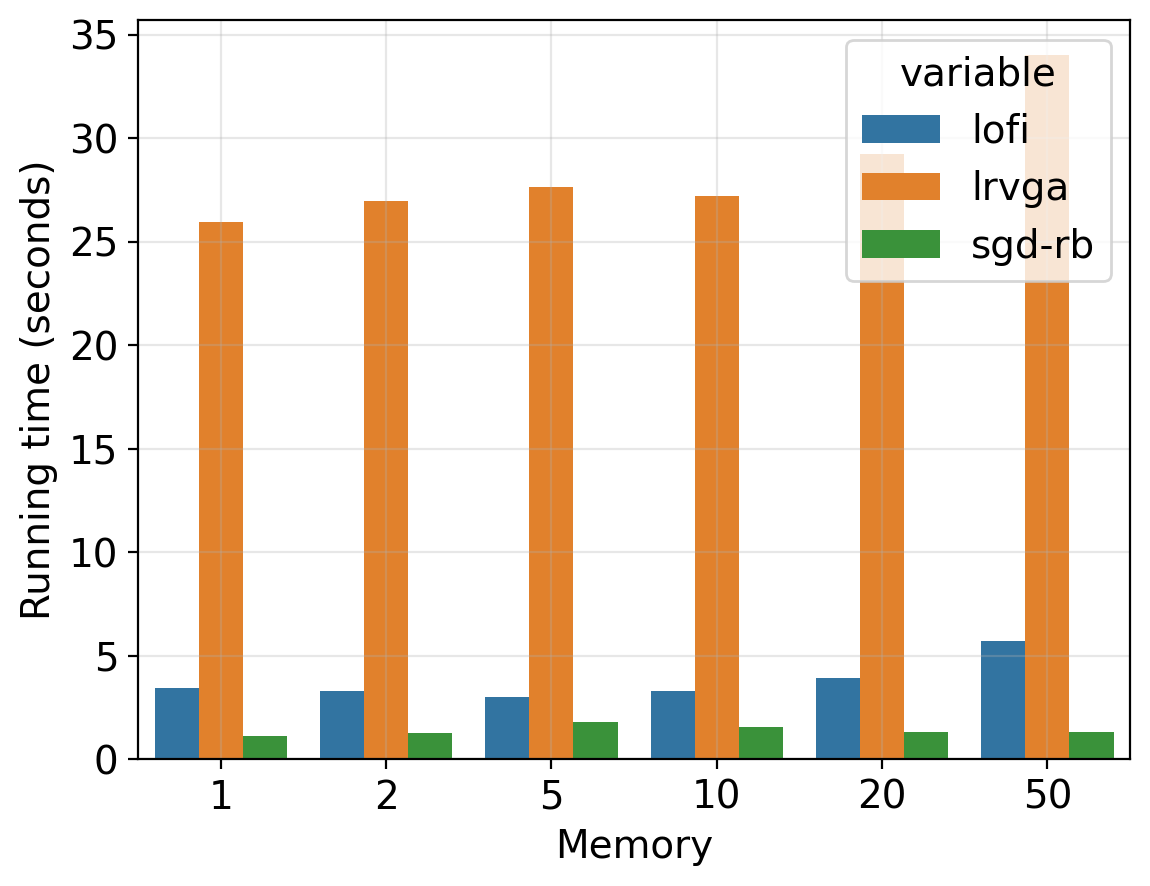

In [440]:
target_agents_time = ["lofi", "lrvga", "sgd-rb"]
data_time = pd.DataFrame(get_subtree(data_dataset, "running_time")).astype(float).T
data_time = data_time[target_agents_time]
data_time.index.name = "rank"
data_time = data_time.reset_index().melt(id_vars="rank")
sns.barplot(data_time, x="rank", y="value", hue="variable")
plt.ylabel("Running time (seconds)")
plt.xlabel("Memory")
plt.grid(alpha=0.3)
plt.savefig(f"./showdown/output/images/{dataset}-running-time.pdf")

In [320]:
colors = {
    'fcekf': np.array([0.12156863, 0.46666667, 0.70588235, 1.        ]),
    'fdekf': np.array([1.        , 0.49803922, 0.05490196, 1.        ]),
    'vdekf': np.array([0.17254902, 0.62745098, 0.17254902, 1.        ]),
    'lofi': np.array([0.83921569, 0.15294118, 0.15686275, 1.        ]),
    'lofi_orth': np.array([0.58039216, 0.40392157, 0.74117647, 1.        ]),
    'lrvga': np.array([0.54901961, 0.3372549 , 0.29411765, 1.        ]),
    'sgd-rb': np.array([0.89019608, 0.46666667, 0.76078431, 1.        ])
}

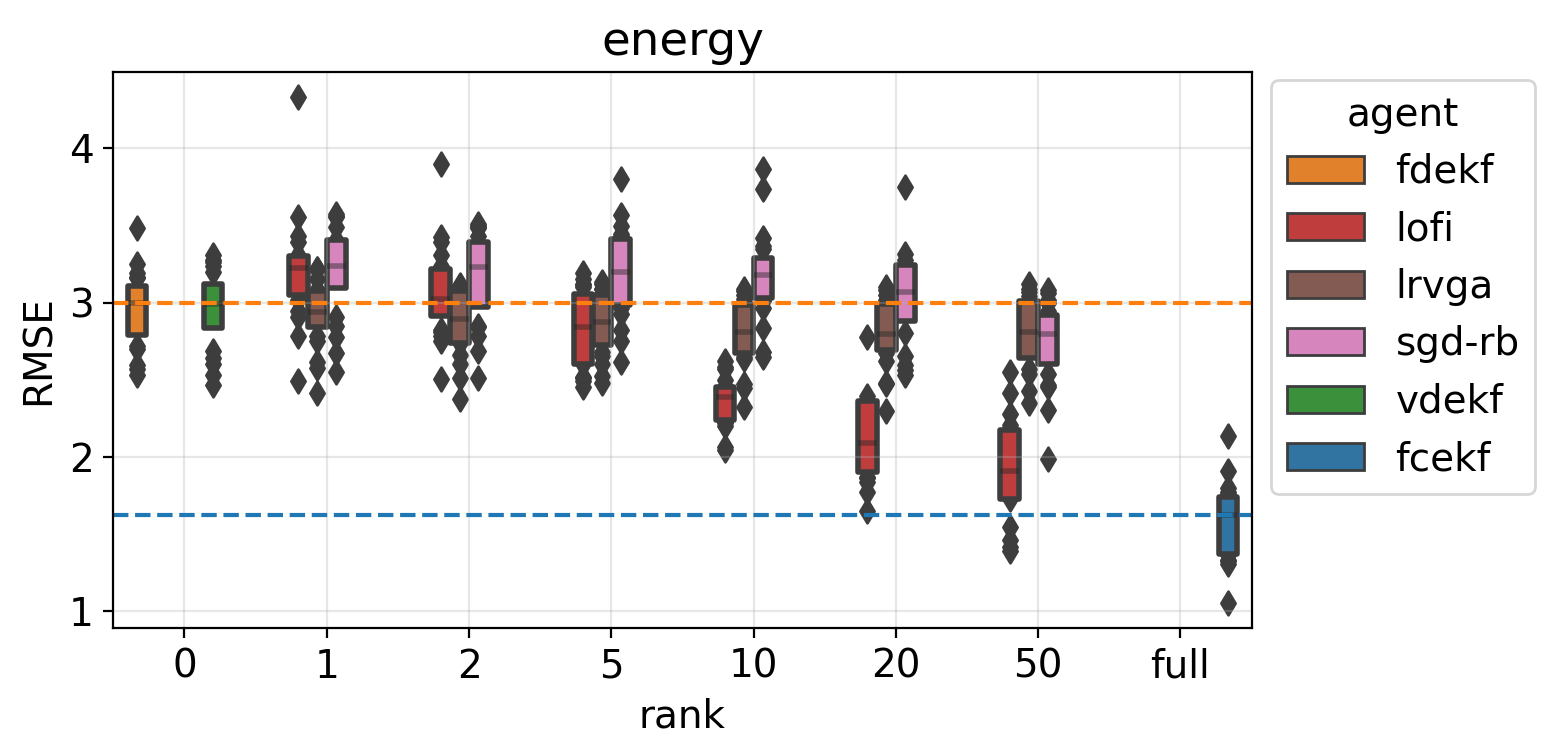

In [321]:
fig, ax = plt.subplots(figsize=(8, 4))

cols_sort = [0, 1, 2, 5, 10, 20, 50, "full"]
void = ["fdekf", "fcekf", "vdekf"]
lbound = df_summary.query("variable == 'fcekf'")["value"].median()
ubound = df_summary.query("variable == 'fdekf'")["value"].median()


sns.boxenplot(hue="variable", y="value", x="rank", data=df_summary, order=cols_sort, palette=colors)
plt.axhline(y=ubound, c="tab:orange", linestyle="--", linewidth=1.5)
plt.axhline(y=lbound, c="tab:blue", linestyle="--", linewidth=1.5)

plt.legend(loc="upper left", title="agent", bbox_to_anchor=(1, 1.02))
plt.ylabel("RMSE")
plt.xlabel("rank")
plt.title(dataset)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f"./showdown/output/images/{dataset}-rank-comparison.pdf")

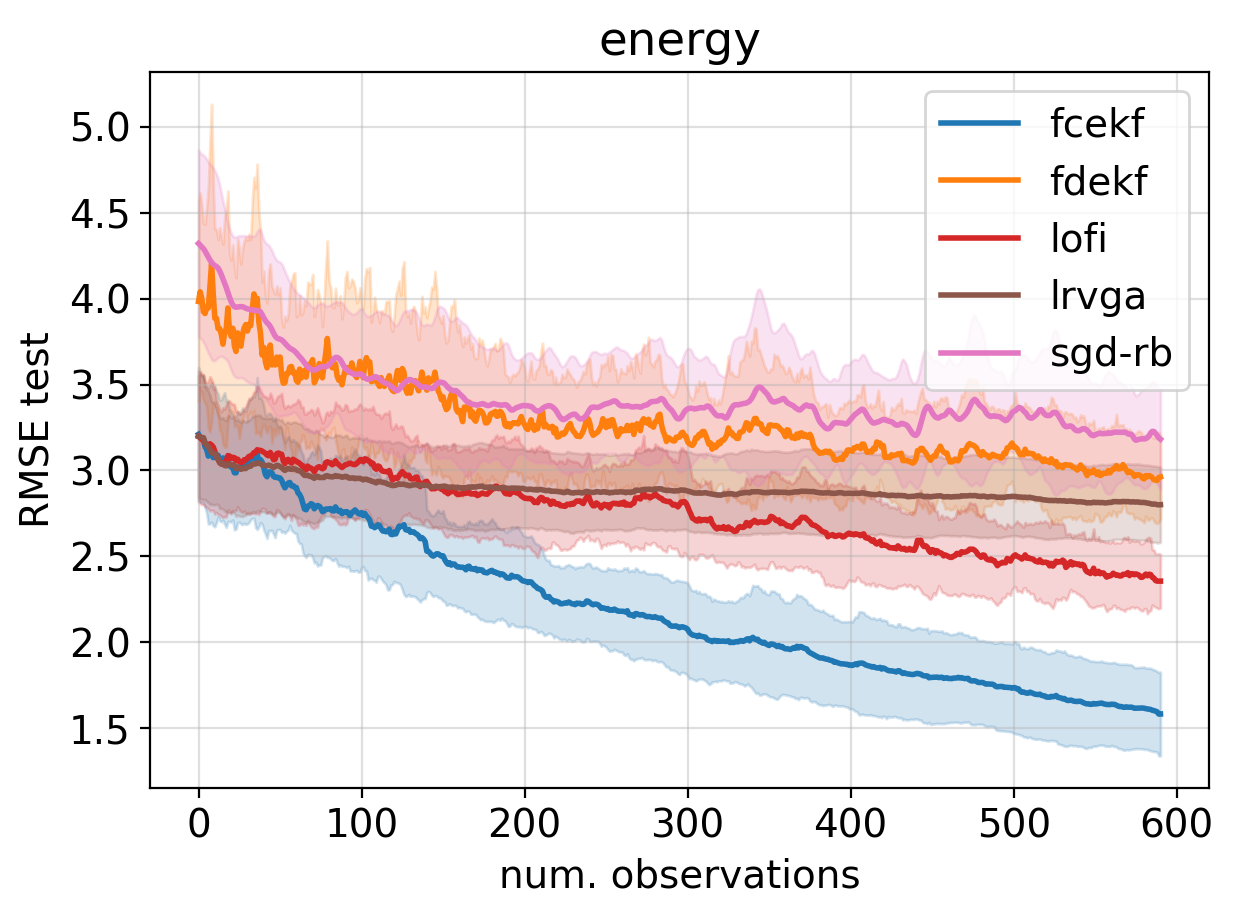

In [322]:
fig, ax = plt.subplots()

rank = 10
for method in order_cols:
    color = colors[method]
    label = f"{method}"
    test_res = pd.DataFrame(data_test[rank][method].T[100:])
    plot_bounds(test_res, ax, color, label, rolling=1)
plt.legend()
plt.ylabel(f"RMSE test")
plt.xlabel("num. observations")
plt.title(dataset)
plt.grid(alpha=0.4)

name_figure = f"{dataset}-rank{rank:02}-test-set.pdf"
plt.tight_layout()
plt.savefig(f"./showdown/output/images/{name_figure}")

## Plot for single dataset, as a function of the rank

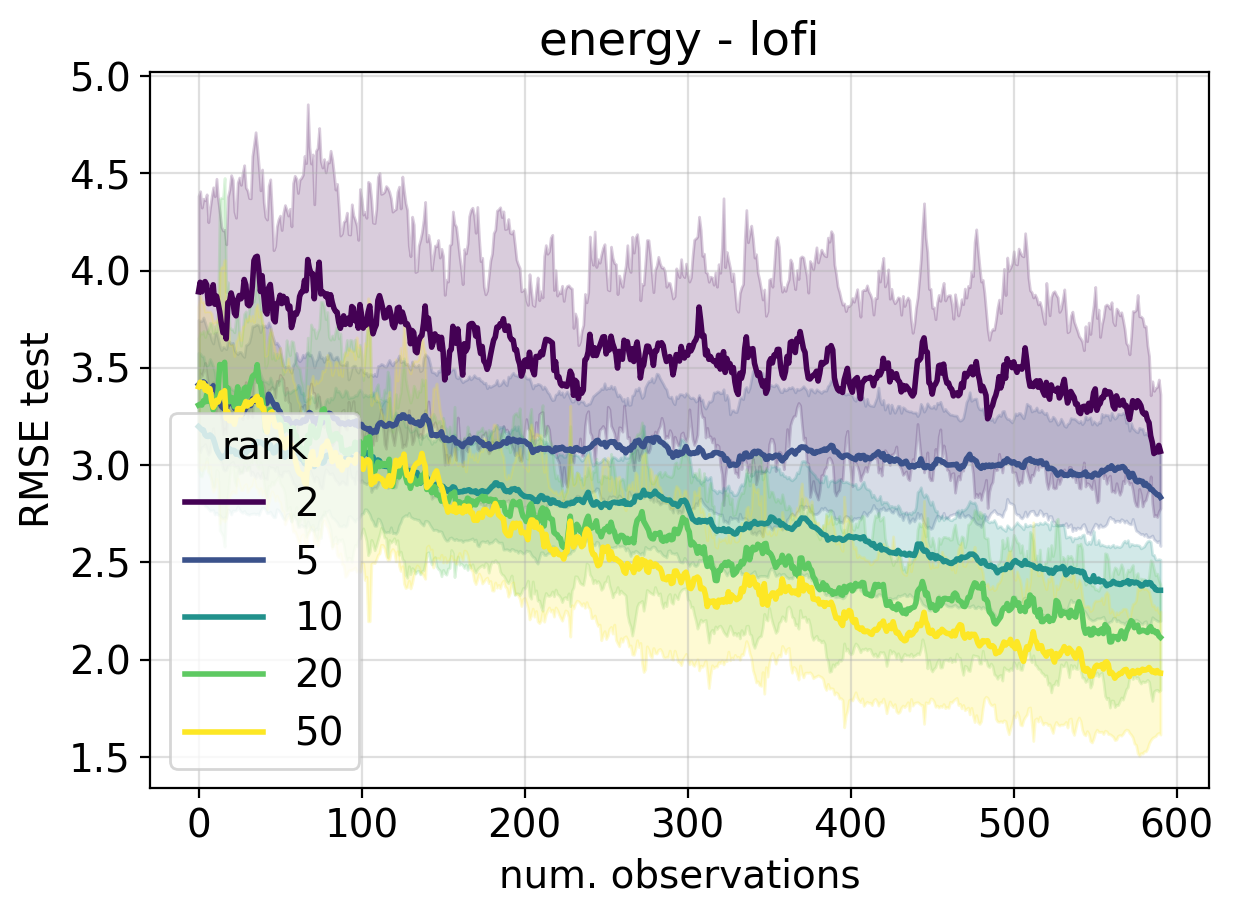

In [323]:
fig, ax = plt.subplots()

ranks = [2, 5, 10, 20, 50]
cmaps = plt.cm.viridis(np.linspace(0, 1, len(ranks)))
method = "lofi"
for color, rank in zip(cmaps, ranks):
    label = rank
    # color = cmaps[rank]
    test_res = pd.DataFrame(data_test[rank][method].T[100:])
    plot_bounds(test_res, ax, color, label, rolling=1)
plt.legend(title="rank", loc="lower left")
plt.ylabel(f"RMSE test")

plt.xlabel("num. observations")
plt.grid(alpha=0.4)
plt.title(f"{dataset} - {method}")
name_figure = f"{dataset}-all-ranks-test-set.pdf"
plt.tight_layout()
plt.savefig(f"./showdown/output/images/{name_figure}")

## Tables!

In [324]:
void_datasets = ["protein-tertiary-structure"]

In [325]:
dataset = "concrete"

df_summaries = []
for dataset in datasets:
    if dataset in void_datasets:
        continue
    files_target = extract_filenames(dataset, path)
    data_dataset = extract_data(files_target, path)
    data_test = get_subtree(data_dataset, "test")
    df_summary = build_df_summary(data_test, dataset)
    df_summaries.append(df_summary)
df_summaries = pd.concat(df_summaries, axis=0)

## LoFi outputs

In [326]:
def format_entry(entry):
    mean = entry.mean()
    std = entry.std()
    label = rf"${mean:0.2f} \pm {std:0.2f}$"
    return label

In [327]:
dfsumm_lofi = (
    df_summaries
    .query("variable=='lofi'")
    # Replace with format_entry for latex output
    .pivot_table(index="dataset", columns="rank", values="value", aggfunc="mean")
)
dfsumm_lofi

rank,1,2,5,10,20,50
dataset,,,,,,
bostonHousing,5.080718,4.383880,4.102889,5.116864,4.876719,8.418413
concrete,8.836946,8.173999,7.766768,7.268073,6.922862,6.619889
energy,3.213861,3.070564,2.834397,2.356136,2.113637,1.930243
kin8nm,0.140268,0.263701,0.150496,0.120652,0.113437,0.105410
naval-propulsion-plant,0.006876,0.002023,0.001273,0.001191,0.002451,0.000464
power-plant,4.364764,4.326953,4.244723,4.202857,4.228817,4.210800
wine-quality-red,0.666648,0.658951,0.653073,0.650432,0.647944,0.882922
yacht,5.760225,5.978009,5.507314,4.658266,4.732761,2.191324


## L-RVGA outputs

In [388]:
dfsumm_lrvga = (
    df_summaries
    .query("variable=='lrvga'")
    # Replace with format_entry for latex output
    .pivot_table(index="dataset", columns="rank", values="value", aggfunc="mean")
)

dfsumm_lrvga

rank,1,2,5,10,20,50
dataset,,,,,,
bostonHousing,4.136014,3.884005,3.710726,3.623823,3.570921,3.586200
concrete,7.453038,7.411405,6.976746,7.279297,6.734220,6.716307
energy,2.924247,2.872354,2.860728,2.800892,2.798979,2.802854
kin8nm,0.135370,0.138369,0.126302,0.119086,0.114295,0.098643
naval-propulsion-plant,NaN,0.003846,0.002714,0.002100,0.001695,0.001047
power-plant,4.254991,4.243989,4.229290,4.217532,4.242579,4.206438
wine-quality-red,0.651652,0.651344,0.650652,0.651245,0.644712,0.642288
yacht,5.055618,4.229970,3.667035,3.387812,2.761082,3.326882


## SGD w/ replay buffer

In [387]:
dfsumm_sgd = (
    df_summaries
    .query("variable=='sgd-rb'")
    # Replace with format_entry for latex output
    .pivot_table(index="dataset", columns="rank", values="value", aggfunc="mean")
)

dfsumm_sgd

rank,1,2,5,10,20,50
dataset,,,,,,
bostonHousing,4.442287,4.311107,4.291359,4.414332,4.385984,4.192142
concrete,9.616455,9.133688,8.717462,8.460921,8.261668,7.709388
energy,3.194648,3.161685,3.183270,3.181982,3.039046,2.732298
kin8nm,0.155616,0.147096,0.136574,0.131691,0.124589,0.119109
naval-propulsion-plant,0.009234,0.008208,0.005288,0.001844,0.000878,0.000401
power-plant,4.405602,4.499103,4.723950,4.814272,4.772392,4.805251
wine-quality-red,0.662220,0.667178,0.681084,0.696468,0.717709,0.762237
yacht,9.839925,9.033509,8.359159,7.918941,7.418996,6.624576


## xKF

In [395]:
target_vars = ["fcekf", "fdekf", "vdekf"]
dfsumm_xkf = (
    df_summaries
    .query("variable in @target_vars")
    # Replace (aggfunc) with format_entry for latex output
    .pivot_table(index="dataset", columns="variable", values="value", aggfunc="mean")
)

dfsumm_xkf

variable,fcekf,fdekf,vdekf
dataset,,,
bostonHousing,4.042458,4.274738,9.033447
concrete,6.448200,7.955693,16.345562
energy,1.582862,2.953248,2.957851
kin8nm,0.100185,0.125806,0.127671
naval-propulsion-plant,0.000575,0.012058,0.010842
power-plant,4.126744,4.254956,4.241130
wine-quality-red,0.657284,0.662691,0.661846
yacht,3.144549,5.669671,5.904977


## Relative performance to FC-EKF

In [331]:
rank = 10
df_rank = [
    dfsumm_xkf["fcekf"], dfsumm_xkf["fdekf"], dfsumm_xkf["vdekf"],
    dfsumm_lofi[rank], dfsumm_lrvga[rank], dfsumm_sgd[rank]
]
df_rank = pd.concat(df_rank, axis=1)

columns = ["fcekf", "fdekf", "vdekf", "lofi", "lrvga", "sgd-rb"]
# ranks = ["Rank 0", "Rank 0", f"Rank {rank}", f"Rank {rank}", f"Rank {rank}"]
# columns = list(zip(ranks, columns))
# columns = pd.MultiIndex.from_tuples(columns)

df_rank.columns = columns

# df_rank = dfsumm_xkf["fcekf"].values[:, None] -  df_rank

### Upper bound on rmse

In [333]:
from rebayes.utils import uci_uncertainty_data

In [334]:
dataset_name = "energy"

coefs_all = {}
for dataset_name in datasets:
    if dataset_name in void_datasets:
        continue
    
    path = path = (
        "/home/gerardoduran/documents/external"
        "/DropoutUncertaintyExps/UCI_Datasets/"
        f"{dataset_name}/"
        "data"
    )

    *_, coefs = uci_uncertainty_data.load_folds_data(path)
    coefs_all[dataset_name] = coefs

coefs_all = jax.tree_map(lambda x: x.mean().item(), coefs_all)
coefs_all = pd.DataFrame.from_dict(coefs_all, orient="index")

In [353]:
df_rank_std = df_rank.divide(coefs_all["ystd"], axis="rows")
df_rank_std = -df_rank_std.drop("fcekf", axis=1).sub(df_rank_std["fcekf"], axis="rows")

columns = ["fdekf", "vdekf", "lofi", "lrvga", "sgd-rb"]
ranks = ["Rank 0", "Rank 0", f"Rank {rank}", f"Rank {rank}", f"Rank {rank}"]
columns = list(zip(ranks, columns))
columns = pd.MultiIndex.from_tuples(columns)

df_rank_std.columns = columns

In [ ]:
print(df_rank_std.applymap(lambda x: f"${x:0.2f}$").style.to_latex())

\begin{tabular}{llllll}
 & \multicolumn{2}{r}{Rank 0} & \multicolumn{3}{r}{Rank 10} \\
 & fdekf & vdekf & lofi & lrvga & sgd-rb \\
dataset &  &  &  &  &  \\
bostonHousing & $-0.03$ & $-0.54$ & $-0.12$ & $0.05$ & $-0.04$ \\
concrete & $-0.09$ & $-0.59$ & $-0.05$ & $-0.05$ & $-0.12$ \\
energy & $-0.14$ & $-0.14$ & $-0.08$ & $-0.12$ & $-0.16$ \\
kin8nm & $-0.10$ & $-0.10$ & $-0.08$ & $-0.07$ & $-0.12$ \\
naval-propulsion-plant & $-0.78$ & $-0.70$ & $-0.04$ & $-0.10$ & $-0.09$ \\
power-plant & $-0.01$ & $-0.01$ & $-0.00$ & $-0.01$ & $-0.04$ \\
wine-quality-red & $-0.01$ & $-0.01$ & $0.01$ & $0.01$ & $-0.05$ \\
yacht & $-0.17$ & $-0.18$ & $-0.10$ & $-0.02$ & $-0.31$ \\
\end{tabular}



In [374]:
latex_table = (
    pd.io.formats.style.Styler(df_rank_std, precision=2)
    .highlight_max(axis=1, props="font-weight: bold;")
)

latex_table